In [1]:
import glob

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import glob

In [2]:
data = pd.read_csv("../data/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")

In [3]:
data[data["study_id"] == 4003253]

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


## Per study:
### 1- Map coords for sagittal (x, y)
### 2- Map coords for axial (y, z)
### 3 Extrapolate the y for axial and z for sagittal from the slice metadata
### 4 Add a buffer 20 px from min and max for each, aggregated per joint

In [178]:
base_path = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
study = 4003253
series = 702807833  #T2STIR for canal stenosis
instance = 9
file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_slice = pydicom.dcmread(file)
data_slice

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.9
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 4003253.1.9
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223713.422388'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '4003253'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.8'
(0018, 5100) Patient Position                   

In [5]:
import torch


# !TODO: Move to util func
def show_mid_slices(img4d):
    if torch.is_tensor(img4d):
        try:
            img4d = img4d.detach().cpu().numpy()
        except Exception as e:
            pass

    for i in range(len(img4d)):
        img3d = img4d[i]
        img_shape = img3d.shape

        a1 = plt.subplot(3, 3, i * 3 + 1)
        a1.imshow(img3d[:, :, img_shape[2] // 2], cmap="hot")
        a1.grid(None)

        a2 = plt.subplot(3, 3, i * 3 + 2)
        a2.imshow(img3d[:, img_shape[1] // 2, :], cmap="hot")
        a2.grid(None)

        a3 = plt.subplot(3, 3, i * 3 + 3)
        a3.imshow(img3d[img_shape[0] // 2, :, :].T, cmap="hot")
        a3.grid(None)

    plt.show()

In [179]:
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

In [180]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

In [8]:
def get_sagittal_bounding_boxes(series_data):
    sagittal_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            sagittal_coords.append([row["level"], i, row["y"], row["x"]])

    sagittal_coords = pd.DataFrame(sagittal_coords, columns=("level", "x", "y", "z"))
    sagittal_coords_groups = sagittal_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    sagittal_coords_groups["x_s"] = sagittal_coords_groups[("x", "min")].values
    sagittal_coords_groups["x_e"] = sagittal_coords_groups[("x", "max")].values
    sagittal_coords_groups["y_s"] = sagittal_coords_groups[("y", "min")].values - 20
    sagittal_coords_groups["y_e"] = sagittal_coords_groups[("y", "max")].values + 20
    sagittal_coords_groups["z_s"] = sagittal_coords_groups[("z", "min")].values - 20
    sagittal_coords_groups["z_e"] = sagittal_coords_groups[("z", "max")].values + 20

    return sagittal_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]

In [9]:
get_sagittal_bounding_boxes(data_for_series)

,x_s,x_e,y_s,y_e,z_s,z_e
,,,,,,
level,,,,,,
L1/L2,8,8,207.964602,247.964602,302.831858,342.831858
L2/L3,8,8,275.714286,315.714286,300.571429,340.571429
L3/L4,8,8,351.818182,391.818182,303.030303,343.030303
L4/L5,8,8,407.327434,447.327434,315.292035,355.292035
L5/S1,8,8,463.964602,503.964602,333.415929,373.415929


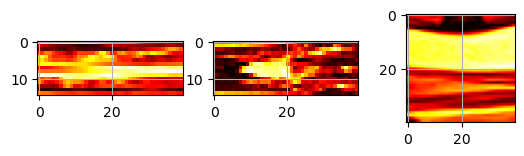

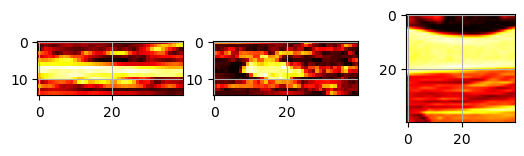

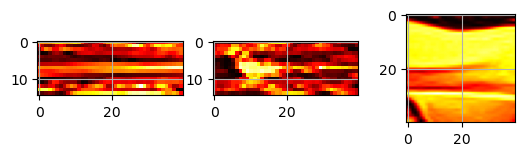

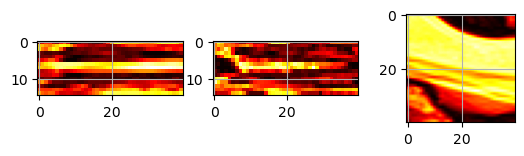

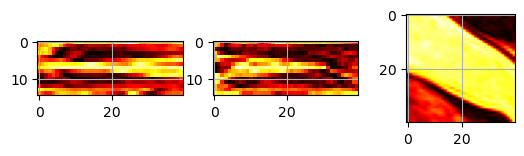

In [10]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [175]:
series = 1054713880  # T1 for foraminal narrowing
instance = 4

file = glob.glob(f"{base_path}/train_images/{study}/{series}/*{instance}.dcm")[0]

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]

# 5. Volume cube detection will be on low definition volumes
# 6. And the diagnosis inference will be based on the full res using the coordinates extracted previously

In [176]:
from rsna_dataloader import *

series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")

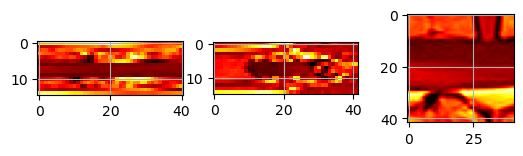

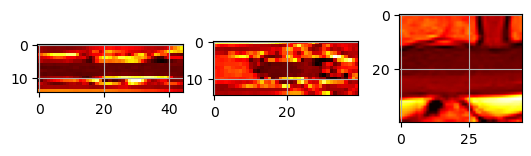

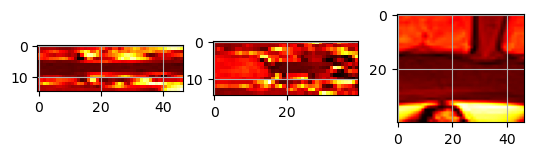

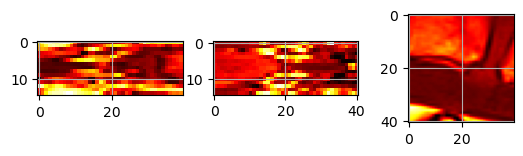

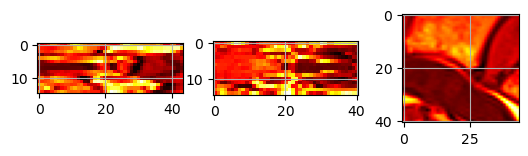

In [13]:
bounding_boxes = get_sagittal_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[:, y_s:y_e, z_s:z_e], 0))

In [14]:
def get_sagittal_vol_masks(volume, series_data):
    ret = []

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        mask = np.zeros(volume.shape)
        # Don't chop x for sagittal
        mask[:, y_s:y_e, z_s:z_e] = 1
        ret.append(mask)

    return ret

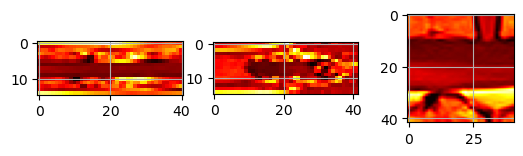

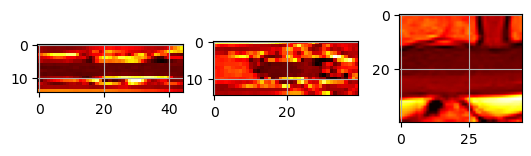

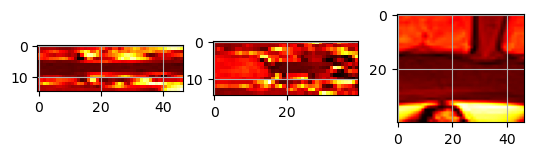

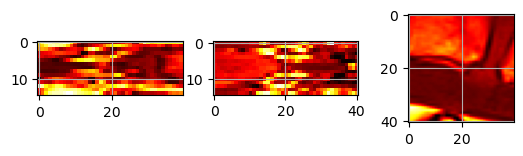

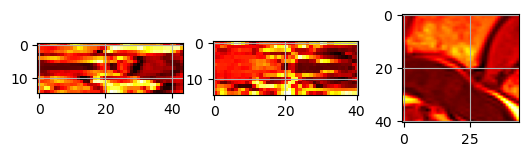

In [15]:
masks = get_sagittal_vol_masks(series_volume, data_for_series)
for mask in masks:
    masked = series_volume * mask

    coords = np.argwhere(masked)
    x_min, y_min, z_min = coords.min(axis=0)
    x_max, y_max, z_max = coords.max(axis=0)
    cropped = masked[x_min:x_max + 1, y_min:y_max + 1, z_min:z_max + 1]

    show_mid_slices(np.expand_dims(cropped, 0))

In [16]:
def get_sagittal_vol_segments(volume, series_data):
    segmentation = np.zeros(volume.shape)

    bounding_boxes = get_sagittal_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        # Don't chop x for sagittal
        segmentation[:, y_s:y_e, z_s:z_e] = level_id + 1

    return segmentation

In [17]:
import torchio as tio

test_subject = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=np.expand_dims(get_sagittal_vol_segments(series_volume, data_for_series), 0)),
    study_id="test",
    series_id="es"
)

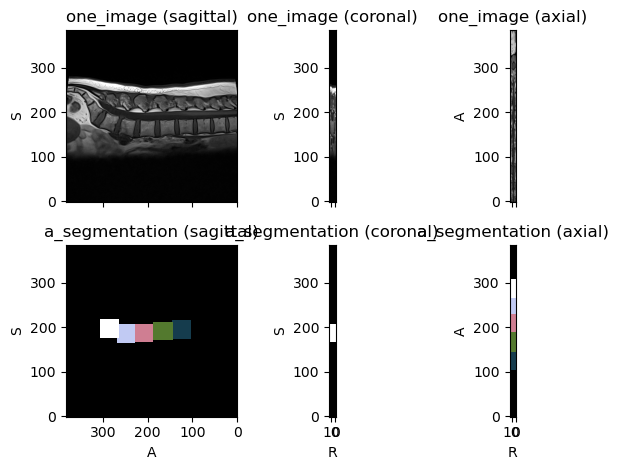

In [18]:
test_subject.plot()

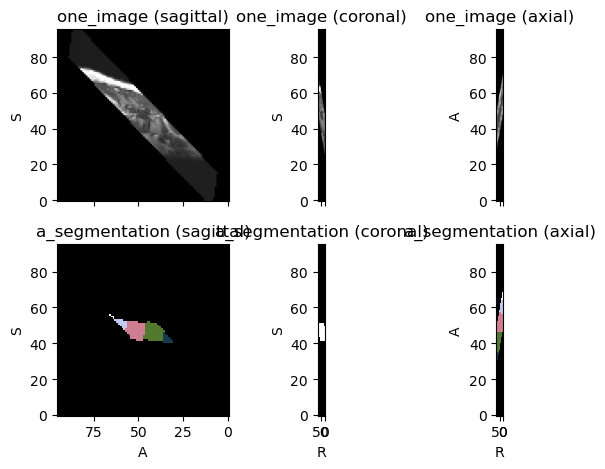

In [19]:
transform_3d = tio.Compose([
    tio.Resize((96, 96, 96), image_interpolation="bspline"),
    tio.RandomAffine(p=1),
])

transform_3d(test_subject).plot()

In [20]:
series = 2448190387

data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]
series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")


def get_axial_bounding_boxes(series_data):
    axial_coords = []
    slice_instances = series_data["instance_number"].unique()

    for i in slice_instances:
        subset = series_data[series_data["instance_number"] == i].sort_values(by="level")
        for index, row in subset.iterrows():
            axial_coords.append([row["level"], i, row["y"], row["x"]])

    axial_coords = pd.DataFrame(axial_coords, columns=("level", "x", "y", "z"))
    axial_coords_groups = axial_coords.groupby("level").agg(("min", "max"))

    # !TODO: Buffer sizes for slices. 1/3 or 1/4 overall maybe
    axial_coords_groups["x_s"] = axial_coords_groups[("x", "min")].values - 3
    axial_coords_groups["x_e"] = axial_coords_groups[("x", "max")].values + 3
    axial_coords_groups["y_s"] = axial_coords_groups[("y", "min")].values - 20
    axial_coords_groups["y_e"] = axial_coords_groups[("y", "max")].values + 20
    axial_coords_groups["z_s"] = axial_coords_groups[("z", "min")].values - 20
    axial_coords_groups["z_e"] = axial_coords_groups[("z", "max")].values + 20

    return axial_coords_groups[["x_s", "x_e", "y_s", "y_e", "z_s", "z_e"]]


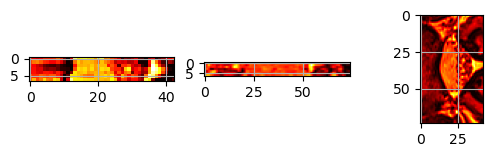

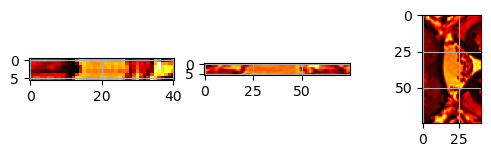

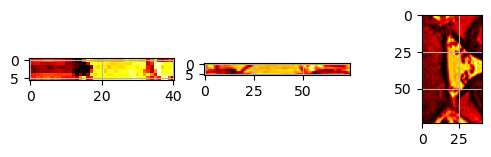

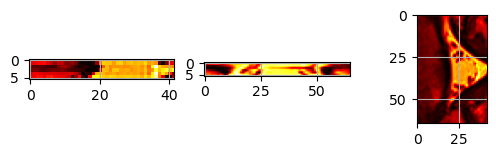

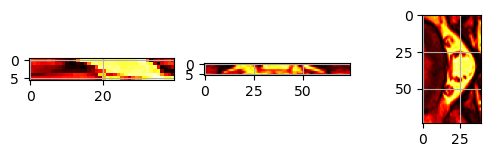

In [21]:
bounding_boxes = get_axial_bounding_boxes(data_for_series)

for level in ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]:
    box = bounding_boxes.loc[level]
    x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

    show_mid_slices(np.expand_dims(series_volume[x_s:x_e, y_s:y_e, z_s:z_e], 0))

In [22]:
def get_axial_vol_segments(volume, series_data):
    ret = []

    bounding_boxes = get_axial_bounding_boxes(series_data)
    for level_id, level in enumerate(["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]):
        box = bounding_boxes.loc[level]
        x_s, x_e, y_s, y_e, z_s, z_e = box.values.astype(int)

        segmentation = np.zeros(volume.shape)
        segmentation[x_s:x_e, y_s:y_e, z_s:z_e] = 1
        ret.append(segmentation)

    return np.array(ret)


In [23]:
test_subject_2 = tio.Subject(
    one_image=tio.ScalarImage(tensor=np.expand_dims(series_volume, 0)),
    a_segmentation=tio.LabelMap(tensor=get_axial_vol_segments(series_volume, data_for_series)),
    study_id="test2",
    series_id="es2"
)

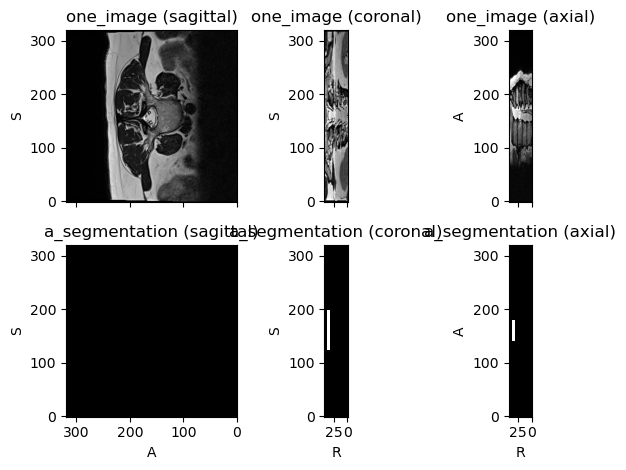

In [24]:
test_subject_2.plot()

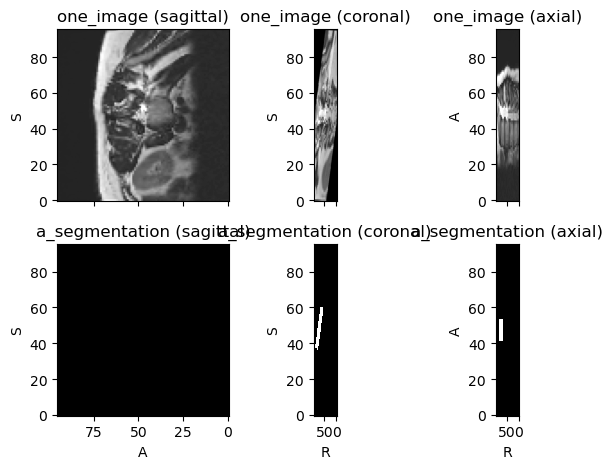

In [25]:
transform_3d(test_subject_2).plot()

In [169]:
from train_segmentation_model import *

# model = UNet(n_channels=1, n_classes=5)
model = torch.load(
    "C:\\Users\\Victor\\Documents\\python-doodles\\models\\sagittal_segmentation_64_3d\\sagittal_segmentation_64_3d_23.pt").to(
    "cuda")

series = 1054713880  # T1 for foraminal narrowing
data_for_series = data[(data["study_id"] == study) & (data["series_id"] == series)]
series_volume = read_series_as_volume(f"{base_path}/train_images/{study}/{series}/")
series_volume = np.repeat(np.expand_dims(series_volume, 0), repeats=2, axis=0)

test_subject_3 = tio.Subject(
    one_image=tio.ScalarImage(tensor=series_volume),
    a_segmentation=tio.LabelMap(tensor=get_sagittal_vol_segments(series_volume, data_for_series)),
    study_id="test3",
    series_id="es3"
)

inp = transform_3d(test_subject_3)
with torch.no_grad():
    out = model(inp.get_images()[0].tensor.unsqueeze(0).to("cuda"))

In [89]:
#https://github.com/milesial/Pytorch-UNet/blob/master/train.py

In [90]:
out.shape, inp["a_segmentation"].tensor.shape

(torch.Size([1, 5, 96, 96, 96]), torch.Size([2, 96, 96, 96]))

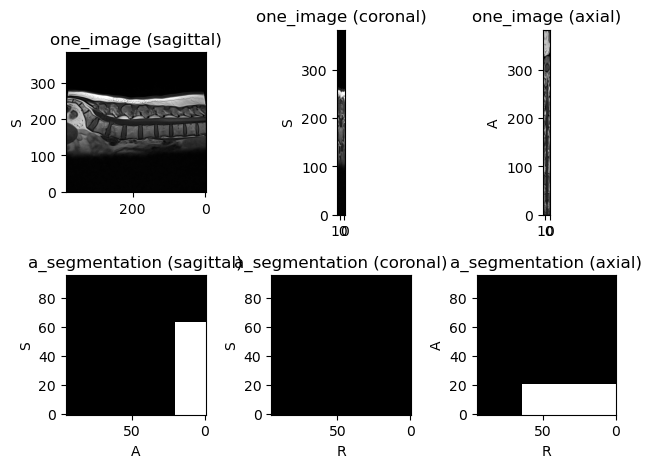

In [114]:
label_test = out.squeeze(0).detach().to("cpu")[4].unsqueeze(0)
label_test_i = torch.unravel_index(label_test.argmax(), label_test.shape)

label_test_ = torch.zeros(label_test.shape)
label_test_[:,
0: label_test_i[1] + 50,
max(0, label_test_i[2] - 10): label_test_i[2] + 20,
0: label_test_i[3] + 20,
] = 1

tio.Subject(
    one_image=tio.ScalarImage(tensor=series_volume),
    a_segmentation=tio.LabelMap(tensor=label_test_),
).plot()

In [78]:
box_pred = out.squeeze(0).detach().to("cpu")[1].unsqueeze(0)
box_pred.shape

torch.Size([1, 96, 96, 96])

In [79]:
box_pred * box_pred

tensor([[[[   936.6445,   3235.5017,   3541.9370,  ...,   1353.2681,
             1121.5667,    672.6934],
          [  1890.5919,   5474.2217,   5739.6240,  ...,   3613.2517,
             3375.8577,   1525.3154],
          [  1816.2273,   4869.3013,   6724.6206,  ...,   4648.8267,
             5438.6304,   2886.3271],
          ...,
          [  1724.1290,   6968.1646,  10290.7725,  ...,  11081.5459,
            12275.7871,   6463.7529],
          [  1952.1222,   6855.9683,  10568.1250,  ...,  10460.5049,
            10908.9902,   6910.8730],
          [  1676.0789,   3935.7195,   5853.9077,  ...,   5158.4663,
             4778.4722,   3005.7827]],

         [[  5960.2520,  14913.5928,  15597.5020,  ...,   8599.7363,
             5604.6162,   3263.5232],
          [ 15418.4346,  34600.9609,  37320.9570,  ...,  25313.6660,
            19880.7461,   9491.7646],
          [ 16625.6895,  37217.8125,  41623.2891,  ...,  27814.2500,
            24863.5234,  14041.1162],
          ...,
     

In [95]:
with torch.no_grad():
    print(SegmentationLoss()(box_pred, F.sigmoid(box_pred)))
    print(F.binary_cross_entropy_with_logits(box_pred, F.sigmoid(box_pred)))
    print(SegmentationLoss().dice_loss(F.sigmoid(box_pred), F.sigmoid(box_pred)))

tensor(0.0237)
tensor(0.0078)
tensor(0.0159)


In [85]:
with torch.no_grad():
    print(SegmentationLoss()(box_pred, 1 - F.sigmoid(box_pred)))
    print(F.binary_cross_entropy_with_logits(box_pred, 1 - F.sigmoid(box_pred)))
    print(SegmentationLoss().dice_loss(F.sigmoid(box_pred), 1 - F.sigmoid(box_pred)))

tensor(131.0688)
tensor(130.0735)
tensor(0.9953)


In [181]:
data_for_series

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


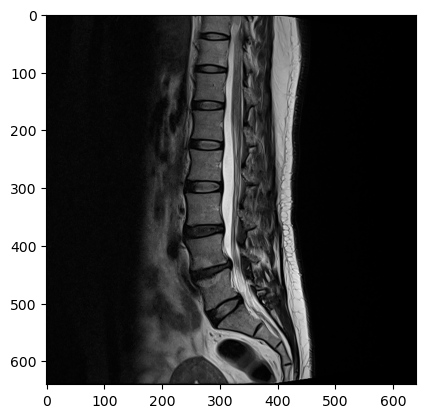

In [183]:
plt.imshow(series_volume[8], cmap="gray")

In [265]:
points = list(zip(data_for_series["x"].values, data_for_series["y"].values))
points

[(322.83185840707966, 227.9646017699115),
 (320.57142857142856, 295.7142857142857),
 (323.03030303030306, 371.8181818181818),
 (335.2920353982301, 427.3274336283186),
 (353.4159292035398, 483.9646017699115)]

In [255]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

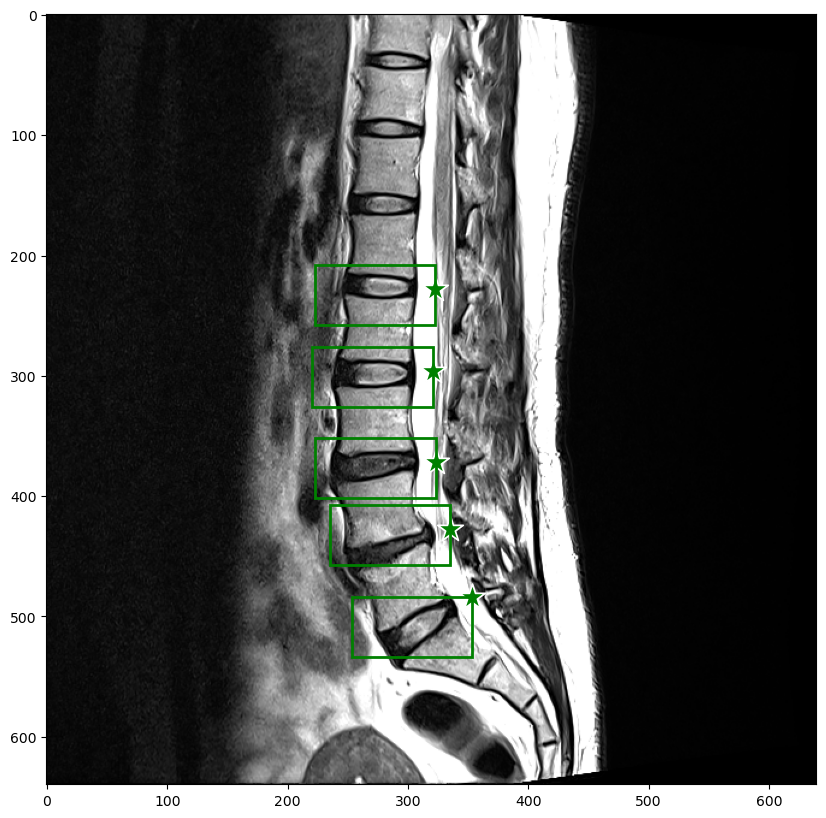

In [293]:
from PIL import Image

raw_image = Image.fromarray(series_volume[8]).convert("RGB")
# mask_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
input_boxes = [[[e[0] - 100, e[1] - 20, e[0], e[1] + 30] for e in points]]

# !TODO: Use some curve fit and normal to expand into disc
input_boxes[0][-1][-1] += 20
input_boxes[0][-1][-3] += 20

input_points = [[e for e in points]]  # 2D location of a window in the image

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0])

In [294]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# inputs = processor(raw_image, input_points=input_points, segmentation_maps=segmentation_map, return_tensors="pt").to(device)
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

In [295]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i + 1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()


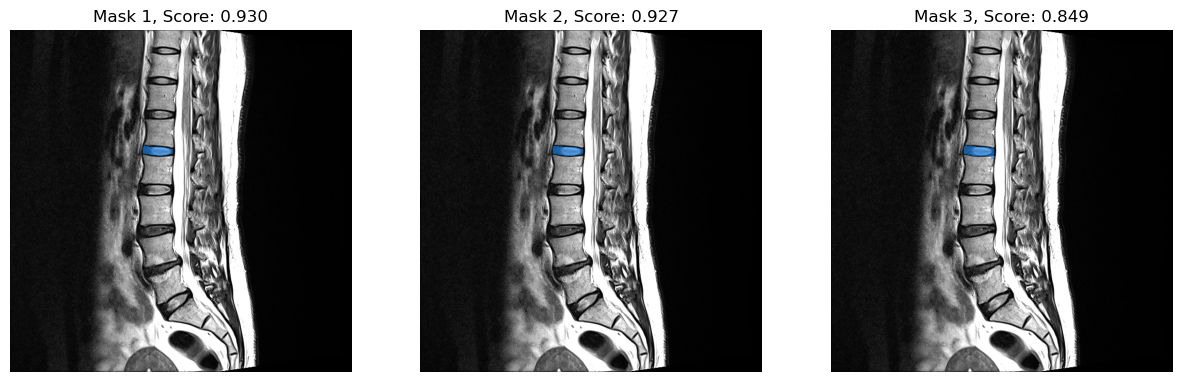

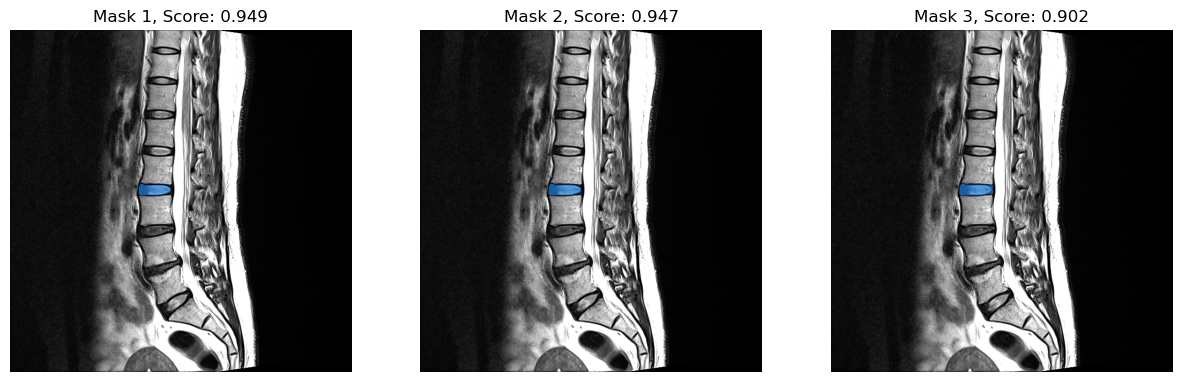

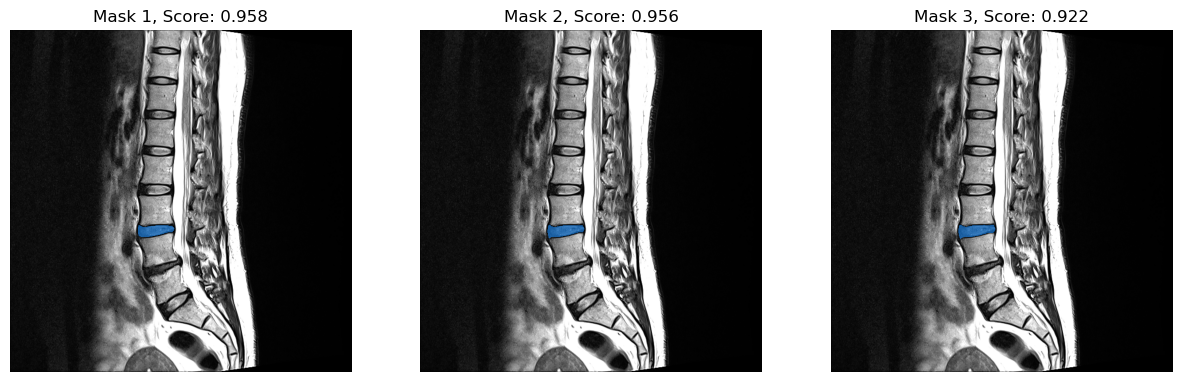

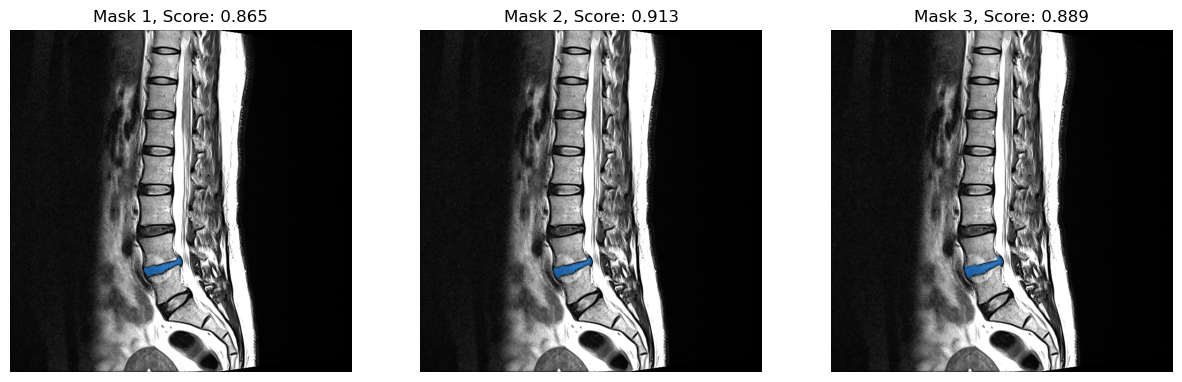

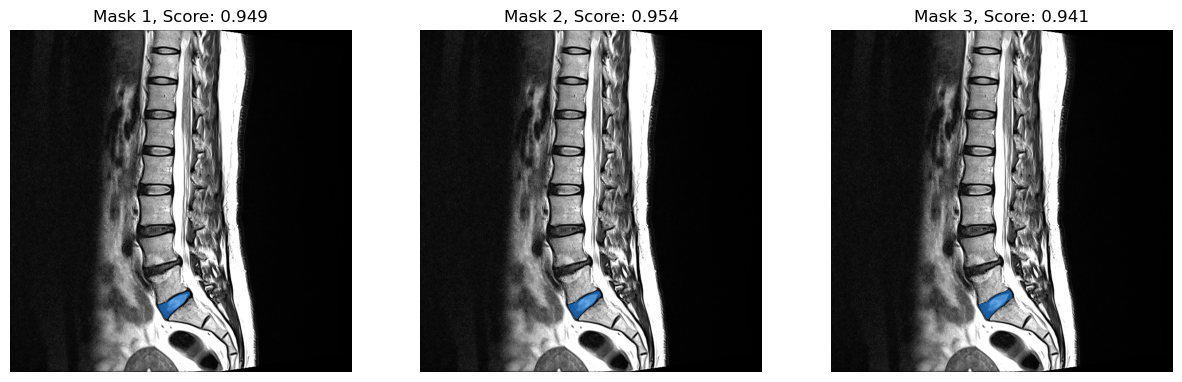

In [296]:
for i in range(len(masks[0])):
    show_masks_on_image(raw_image, masks[0][i], scores[:, i, :])

In [341]:
import cv2


def get_mask_centroids(mask):
    ret = []
    
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
    
        ret.append((cX, cY))
    
    return ret

In [342]:
test_mask = (masks[0][0][0].numpy() * 1).astype(np.uint8)
test_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

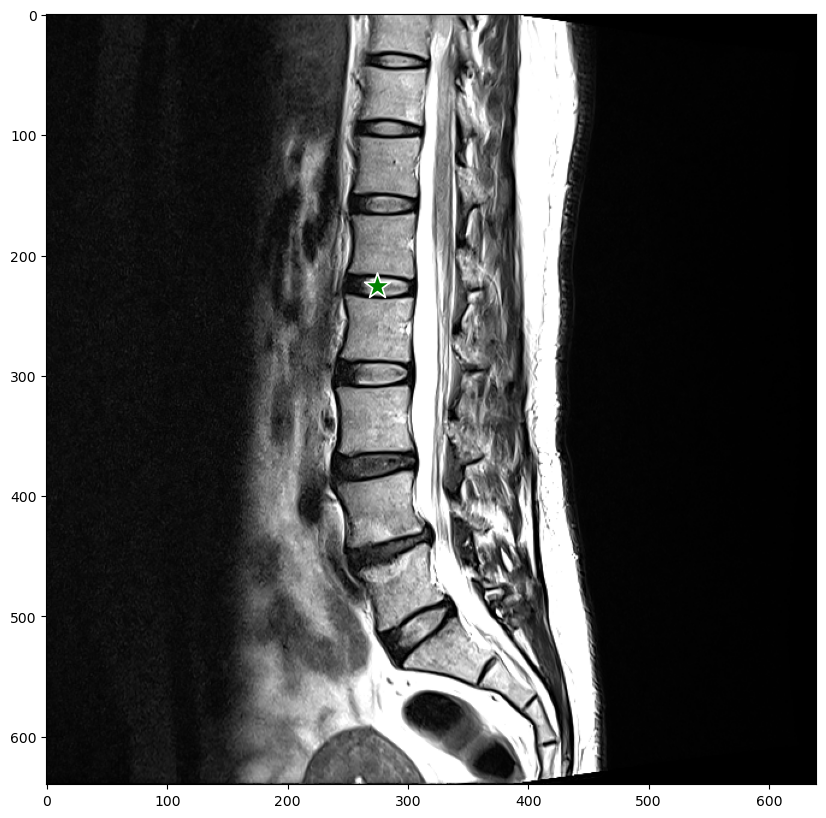

In [344]:
show_points_on_image(raw_image, get_mask_centroids(test_mask))